In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Aug 27 14:52:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn import metrics
from tensorflow.keras import datasets,layers,models
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tqdm import tqdm
from typing import List, Tuple

# Setting up convenience functions

In [34]:
def get_predictions_from_model(nnmodel, X_TEST : np.array ) -> np.array:
  """
  Returns the predictions for the convolutional model.
  Takes as parameters the X_TEST holdout dataset
  """
  predictions = nnmodel.predict(X_TEST)
  return np.argmax(predictions, axis = 1) # Get the most probable class


def get_original_labels(predictions: np.array,encoder: OrdinalEncoder) -> np.array:
  """
  The function returns the original labels (before ordinal encoding).
  """
  return encoder.inverse_transform(predictions.reshape(-1,1))


def plot_image(Image_array: np.array,
                predictions_array: pd.DataFrame,
                index: int
                ) -> None:
  """
  Convenience Function. Plots the image given an image array
  (usually test images) and draws the true and predicted image class
  """
  fig, ax = plt.subplots(figsize = (8,8))
  ax.imshow(Image_array[index][:,:,::-1]) # [:,:,::-1] is nessecary for colors to depict correctly (reverses rgb channels)
  plt.title(f"Predicted Label {predictions_array.iloc[index,0]}") # First Columns contains correct Predictions
  plt.axis('off')


def plot_multiple_images(Image_array: np.array,
                         predictions_array: pd.DataFrame,
                         indexes: List,
                         figsize: Tuple,
                         ) -> None:

  fig = plt.figure(figsize = figsize)
  ROWS = len(indexes)
  for i,index in enumerate(indexes):

    fig.add_subplot(ROWS,1,(i+1)) # show images in single row
    plt.imshow(Image_array[index][:,:,::-1]) # [:,:,::-1] is nessecary for colors to depict correctly (reverses rgb channels)
    plt.axis('off')
    plt.title(f"Predicted Label: {predictions_array.loc[index,'Ypred']}, True Label: {predictions_array.loc[index,'Ytrue']}")


def plot_keras_history(history):
    """
    :param history: 
    :return: 
    """
    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()



In [5]:
# Hyper Parameters
IMG_SIZE = (200,200)
INPUT_SHAPE = (200,200,3)
TEST_SIZE = 0.25
BATCH_SIZE = 32
EPOCHS = 100

## Reading the images and preparing data

In [6]:
loaded = np.load('/content/drive/MyDrive/models/data.npz', allow_pickle = True)
X = loaded['a']
Y = loaded['b']

In [7]:
encoder = OrdinalEncoder()
Y = encoder.fit_transform(Y.reshape(-1,1))

In [8]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X,Y,test_size = TEST_SIZE, stratify = Y, random_state = 42)
X_TRAIN = X_TRAIN/255
X_TEST = X_TEST/255
print(f"Number of Training Images {X_TRAIN.shape[0]}")
print(f"Number of Test Images {X_TEST.shape[0]}")
print(f"Number of total products {len(np.unique(Y))}")

Number of Training Images 4070
Number of Test Images 1357
Number of total products 135


# Model Building


## Custom Convolutional Netowrk

In [10]:
es = [] #Call backs

es.append(
    EarlyStopping(
                  monitor   = 'accuracy', # which metric we want to use as criterion to stop training
                  min_delta = 0.00, # Minimum change in the monitored quantity to qualify as an improvement
                  patience  = 5, 
                  verbose   = 1, # verbosity level
                  mode      = 'auto',
                  restore_best_weights = True))
es.append(
    ReduceLROnPlateau(monitor = 'accuracy',
                      factor = 0.1,
                      patience = 3,
                      verbose = 1)
    )

In [11]:
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(64, (3,3), activation = 'relu', input_shape = INPUT_SHAPE))
conv_model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
conv_model.add(layers.MaxPooling2D(2,2))

conv_model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
conv_model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
conv_model.add(layers.MaxPooling2D(2,2))

conv_model.add(layers.Flatten())

conv_model.add(layers.Dense(4096,activation = 'relu'))
conv_model.add(layers.BatchNormalization())
conv_model.add(layers.Dense(len(np.unique(Y_TRAIN)),activation = 'softmax'))
conv_model.summary()
conv_model.compile(optimizer = 'adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 196, 196, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 94, 94, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 47, 47, 64)       0         
 2D)                                                    

In [12]:
history = conv_model.fit(X_TRAIN,Y_TRAIN,
                         epochs = EPOCHS,
                         validation_split = 0.25,
                         callbacks = es)

Epoch 1/100
96/96 [==============================] - 31s 194ms/step - loss: 2.2777 - accuracy: 0.5590 - val_loss: 26.7257 - val_accuracy: 0.0491 - lr: 0.0010
Epoch 2/100
96/96 [==============================] - 14s 149ms/step - loss: 0.3815 - accuracy: 0.9010 - val_loss: 11.2269 - val_accuracy: 0.1611 - lr: 0.0010
Epoch 3/100
96/96 [==============================] - 14s 147ms/step - loss: 0.1339 - accuracy: 0.9643 - val_loss: 1.5607 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 4/100
96/96 [==============================] - 14s 149ms/step - loss: 0.0176 - accuracy: 0.9964 - val_loss: 1.0286 - val_accuracy: 0.7898 - lr: 0.0010
Epoch 5/100
96/96 [==============================] - 14s 147ms/step - loss: 0.0113 - accuracy: 0.9974 - val_loss: 0.8105 - val_accuracy: 0.8261 - lr: 0.0010
Epoch 6/100
96/96 [==============================] - 14s 148ms/step - loss: 0.0065 - accuracy: 0.9990 - val_loss: 1.1962 - val_accuracy: 0.7721 - lr: 0.0010
Epoch 7/100
96/96 [==============================] - 14s

In [13]:
# Get Predictions
predictions = get_predictions_from_model(conv_model,X_TEST)
label_pred = get_original_labels(predictions,encoder)
label_true = get_original_labels(Y_TEST,encoder)

predictions_dataframe = pd.DataFrame({'Ytrue':label_true.reshape(-1), 'Ypred':label_pred.reshape(-1)})
correct_predictions = predictions_dataframe[predictions_dataframe['Ytrue']==predictions_dataframe['Ypred']]
false_predictions = predictions_dataframe[predictions_dataframe['Ytrue']!=predictions_dataframe['Ypred']]
print(f"Test Sample size {X_TEST.shape[0]}")
print(f"Number of correct Predctions {correct_predictions.shape[0]}")
print(f"Accuracy of Test Dataset {correct_predictions.shape[0]/X_TEST.shape[0]:.4f}")

Test Sample size 1357
Number of correct Predctions 1157
Accuracy of Test Dataset 0.8526


In [14]:
conv_model.save("/content/drive/MyDrive/models/conv_model.h5") # Save...
conv_model.save_weights("/content/drive/MyDrive/models/conv_model_weights.h5")

!ls -lh /content/drive/MyDrive/models # Check that it is there...

assets		       data.npz		       keras_metadata.pb  variables
conv_model.h5	       inception.h5	       resnet.h5	  vgg
conv_model_weights.h5  inceptionv3_150_150.h5  saved_model.pb	  vgg16.h5


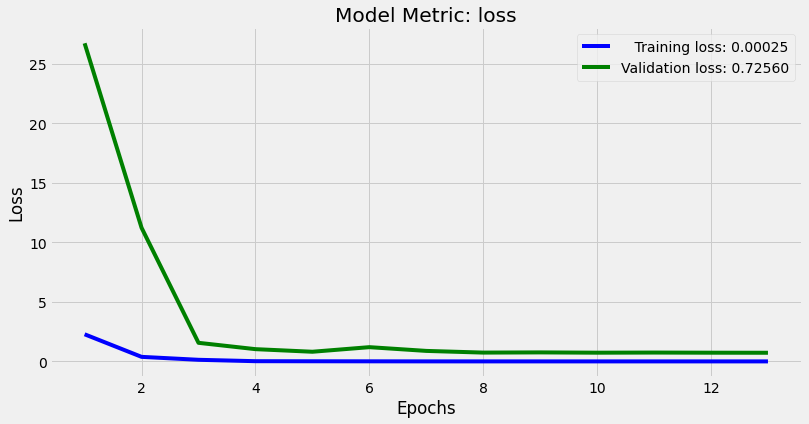

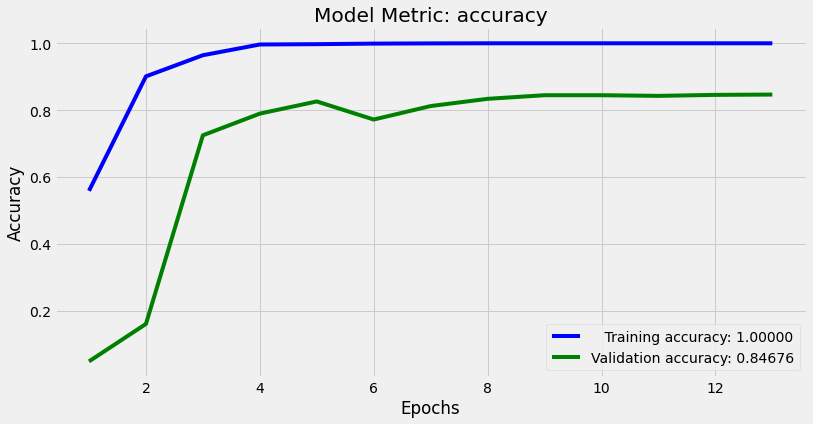

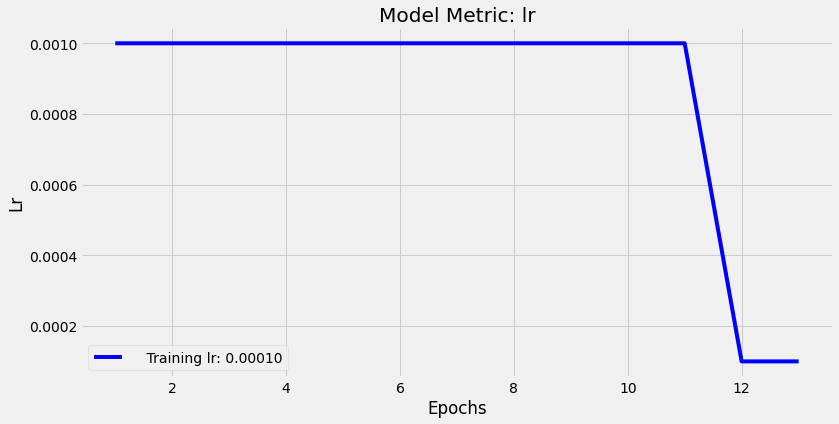

In [17]:
plt.style.use('fivethirtyeight')
plot_keras_history(history)

In [71]:
print(predictions.shape)
print(Y_TEST.reshape(-1).shape)

(1357,)
(1357,)


In [ ]:
np.unique([x[0] for x in label_true])

In [106]:
def calculate_scores(label_true: np.array, label_pred:np.array) -> pd.DataFrame:

  scores = pd.DataFrame(data = {
            "labels" : np.unique([x[0] for x in label_true]),
            "f1_score": metrics.f1_score(label_true, label_pred, average = None),
            "precision": metrics.precision_score(label_true, label_pred, average = None),
            "recall" : metrics.recall_score(label_true, label_pred, average = None)
            }
          )
  return scores
scores = calculate_scores(label_true, label_pred)
scores.sort_values(by = ["f1_score"], ascending = True).head(10) # worst classes by f1_score
scores.sort_values(by = ["f1_score"], ascending = False).head(10) # worst classes by f1_score


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,labels,f1_score,precision,recall
116,SKIP KAPSOULES 20 MEZOURES SPRING FRESH,0.000000,0.000000,0.000000
118,SKIP POWER CLEAN 70 MEZOYRES,0.000000,0.000000,0.000000
68,KLINEX XLORINI ULTRA LEVANTE,0.222222,0.200000,0.250000
115,SKIP KAPSOULES 20 MEZOURES POWER CLEAN,0.250000,0.500000,0.166667
4,AIM WHITE SYSTEM ENAMEL 75ml,0.285714,0.500000,0.200000
44,DODONI YOGURT STRAINED 2,0.333333,1.000000,0.200000
27,COLGATE MAX WHITE CHARCOAL 75ml,0.363636,0.500000,0.285714
95,OMO 45 MEZOURES TROPIKA LOYLOYDIA,0.400000,0.500000,0.333333
29,COLGATE SENSITIVE INSTANT RELIEF 75ml,0.476190,0.416667,0.555556
101,PARONDONTAX COMPLETE PROTECTION WHITE 75ml,0.476190,0.416667,0.555556


## VGG16

In [107]:
# Clean up
del conv_model
del history

In [108]:
from tensorflow.keras.applications import VGG16

In [109]:
vgg16model = VGG16(include_top = False, input_shape = INPUT_SHAPE)

58900480/58889256 [==============================] - 0s 0us/step


In [111]:
vgg16model.trainable = False

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(4096, activation='relu')
dense_layer_2 = layers.Dense(4096, activation='relu')
batch_normalization = layers.BatchNormalization()
prediction_layer = layers.Dense(len(np.unique(Y_TRAIN)),activation = 'softmax')


In [112]:
vgg16 = models.Sequential([
    vgg16model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    batch_normalization,
    prediction_layer
])

In [113]:
vgg16.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
vgg16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_2 (Dense)             (None, 4096)              75501568  
                                                                 
 dense_3 (Dense)             (None, 4096)              16781312  
                                                                 
 batch_normalization_1 (Batc  (None, 4096)             16384     
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 135)               553095    
                                                      

In [114]:
history_vgg16 = vgg16.fit(X_TRAIN,Y_TRAIN,
                          epochs = EPOCHS,
                          validation_split = 0.25,
                          callbacks = es)

Epoch 1/100
96/96 [==============================] - 13s 120ms/step - loss: 1.6799 - accuracy: 0.6907 - val_loss: 36.8208 - val_accuracy: 0.0108 - lr: 0.0010
Epoch 2/100
96/96 [==============================] - 10s 100ms/step - loss: 0.2101 - accuracy: 0.9531 - val_loss: 10.9758 - val_accuracy: 0.1444 - lr: 0.0010
Epoch 3/100
96/96 [==============================] - 10s 100ms/step - loss: 0.0544 - accuracy: 0.9875 - val_loss: 7.5483 - val_accuracy: 0.2014 - lr: 0.0010
Epoch 4/100
96/96 [==============================] - 10s 99ms/step - loss: 0.0309 - accuracy: 0.9921 - val_loss: 3.6623 - val_accuracy: 0.4096 - lr: 0.0010
Epoch 5/100
96/96 [==============================] - 10s 100ms/step - loss: 0.0076 - accuracy: 0.9980 - val_loss: 0.6279 - val_accuracy: 0.8487 - lr: 0.0010
Epoch 6/100
96/96 [==============================] - 9s 98ms/step - loss: 0.0711 - accuracy: 0.9889 - val_loss: 6.8595 - val_accuracy: 0.2220 - lr: 0.0010
Epoch 7/100
96/96 [==============================] - 9s 97m

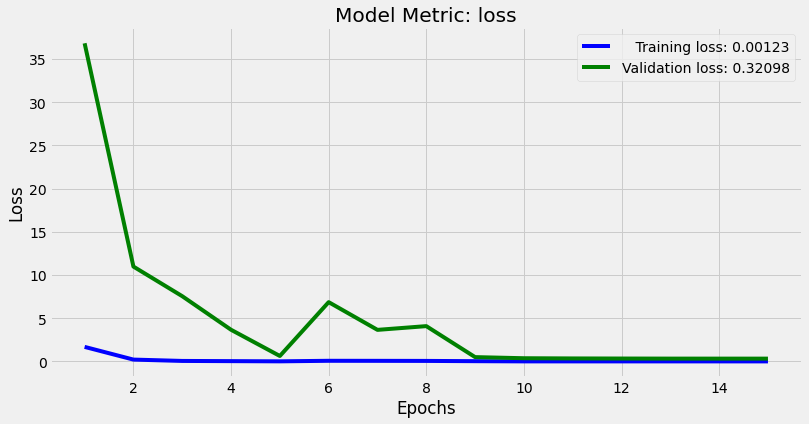

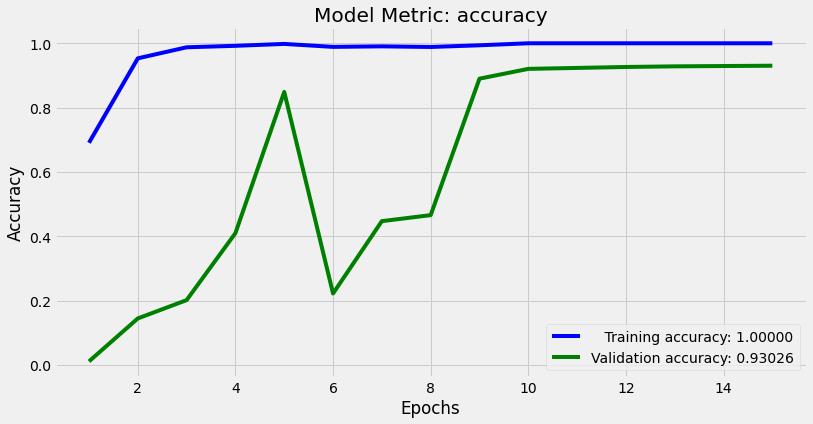

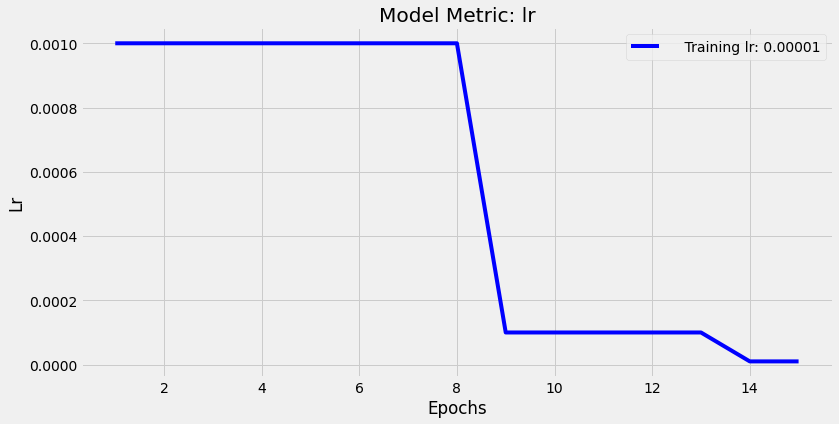

In [115]:
plot_keras_history(history_vgg16)

In [116]:
vgg16.save("/content/drive/MyDrive/models/vgg16.h5")
vgg16.save_weights("/content/drive/MyDrive/models/vgg16_weights.h5")

In [117]:
predictions = get_predictions_from_model(vgg16,X_TEST)
label_pred = get_original_labels(predictions,encoder)
label_true = get_original_labels(Y_TEST,encoder)

predictions_dataframe = pd.DataFrame({'Ytrue':label_true.reshape(-1), 'Ypred':label_pred.reshape(-1)})
correct_predictions = predictions_dataframe[predictions_dataframe['Ytrue']==predictions_dataframe['Ypred']]
false_predictions = predictions_dataframe[predictions_dataframe['Ytrue']!=predictions_dataframe['Ypred']]

In [118]:
print(f"Test Sample size {X_TEST.shape[0]}")
print(f"Number of correct Predctions {correct_predictions.shape[0]}")
print(f"Accuracy of Test Dataset {correct_predictions.shape[0]/X_TEST.shape[0]:.4f}")

Test Sample size 1357
Number of correct Predctions 1245
Accuracy of Test Dataset 0.9175


## RESNET50

In [119]:
resnet_model = models.Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=INPUT_SHAPE,
                   pooling='max',
                   weights='imagenet')

for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

94781440/94765736 [==============================] - 1s 0us/step


In [120]:
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(4096, activation='relu'))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Dense(len(np.unique(Y_TRAIN)), activation='softmax'))

In [121]:
from tensorflow.keras.optimizers import Adam

In [122]:
resnet_model.compile(optimizer=Adam(lr=0.001),
                     loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                     metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [123]:
history_resnet = resnet_model.fit(X_TRAIN,Y_TRAIN,
                           validation_split=0.25,
                           epochs=EPOCHS,
                           callbacks = es
                           )

Epoch 1/100
96/96 [==============================] - 13s 93ms/step - loss: 2.6962 - accuracy: 0.4948 - val_loss: 26.9845 - val_accuracy: 0.0236 - lr: 0.0010
Epoch 2/100
96/96 [==============================] - 7s 72ms/step - loss: 0.8097 - accuracy: 0.8178 - val_loss: 11.2984 - val_accuracy: 0.1090 - lr: 0.0010
Epoch 3/100
96/96 [==============================] - 7s 72ms/step - loss: 0.3976 - accuracy: 0.9007 - val_loss: 6.7721 - val_accuracy: 0.2269 - lr: 0.0010
Epoch 4/100
96/96 [==============================] - 7s 72ms/step - loss: 0.2806 - accuracy: 0.9322 - val_loss: 3.7478 - val_accuracy: 0.4538 - lr: 0.0010
Epoch 5/100
96/96 [==============================] - 7s 72ms/step - loss: 0.1741 - accuracy: 0.9567 - val_loss: 3.0134 - val_accuracy: 0.5560 - lr: 0.0010
Epoch 6/100
96/96 [==============================] - 7s 71ms/step - loss: 0.1493 - accuracy: 0.9676 - val_loss: 9.1434 - val_accuracy: 0.1847 - lr: 0.0010
Epoch 7/100
96/96 [==============================] - 7s 72ms/step -

In [125]:
resnet_model.save("/content/drive/MyDrive/models/resnet.h5")
resnet_model.save_weights("/content/drive/MyDrive/models/resnet_weights.h5")

In [131]:
! ls -lh /content/drive/MyDrive/models

total 12G
drwx------ 2 root root 4.0K Aug 23 16:08 assets
-rw------- 1 root root 6.5G Aug 27 15:05 conv_model.h5
-rw------- 1 root root 2.2G Aug 27 15:06 conv_model_weights.h5
-rw------- 1 root root 455M Aug 27 07:21 data.npz
-rw------- 1 root root  87M Aug 27 08:17 inception.h5
-rw------- 1 root root  87M Aug 24 13:12 inceptionv3_150_150.h5
-rw------- 1 root root 949K Aug 24 13:12 keras_metadata.pb
-rw------- 1 root root 193M Aug 27 17:53 resnet.h5
-rw------- 1 root root 125M Aug 27 17:53 resnet_weights.h5
-rw------- 1 root root 5.1M Aug 24 13:12 saved_model.pb
drwx------ 2 root root 4.0K Aug 24 13:12 variables
drwx------ 2 root root 4.0K Aug 23 16:08 vgg
-rw------- 1 root root 1.1G Aug 27 17:08 vgg16.h5
-rw------- 1 root root 411M Aug 27 17:08 vgg16_weights.h5


In [126]:
predictions = get_predictions_from_model(resnet_model,X_TEST)
label_pred = get_original_labels(predictions,encoder)
label_true = get_original_labels(Y_TEST,encoder)

predictions_dataframe = pd.DataFrame({'Ytrue':label_true.reshape(-1), 'Ypred':label_pred.reshape(-1)})
correct_predictions = predictions_dataframe[predictions_dataframe['Ytrue']==predictions_dataframe['Ypred']]
false_predictions = predictions_dataframe[predictions_dataframe['Ytrue']!=predictions_dataframe['Ypred']]

print(f"Test Sample size {X_TEST.shape[0]}")
print(f"Number of correct Predctions {correct_predictions.shape[0]}")
print(f"Accuracy of Test Dataset {correct_predictions.shape[0]/X_TEST.shape[0]:.4f}")

Test Sample size 1357
Number of correct Predctions 1112
Accuracy of Test Dataset 0.8195


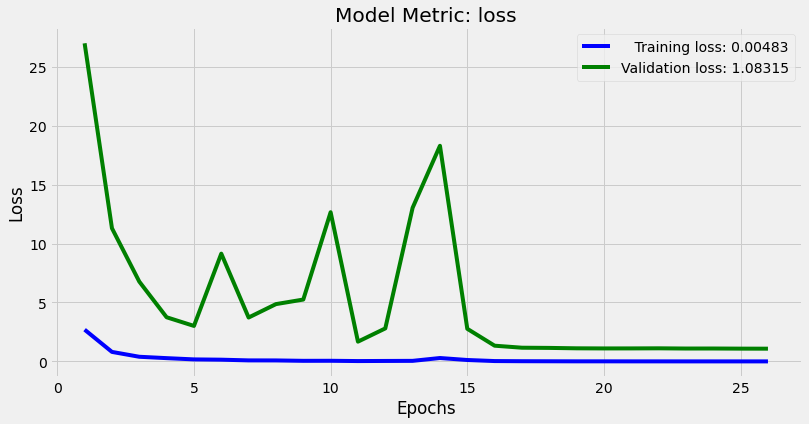

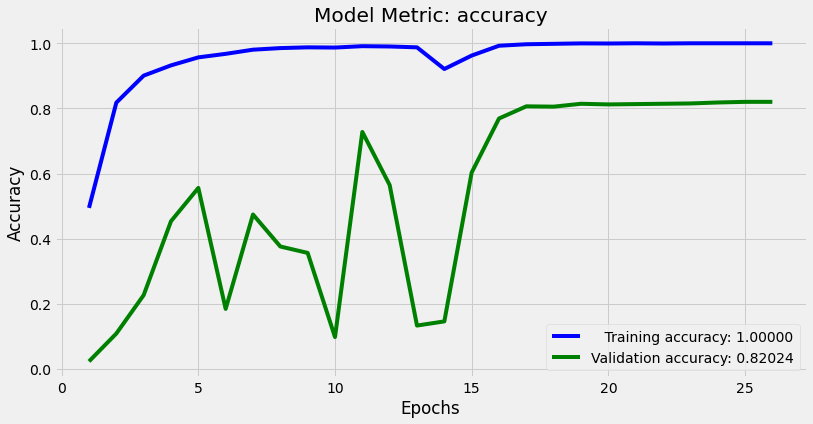

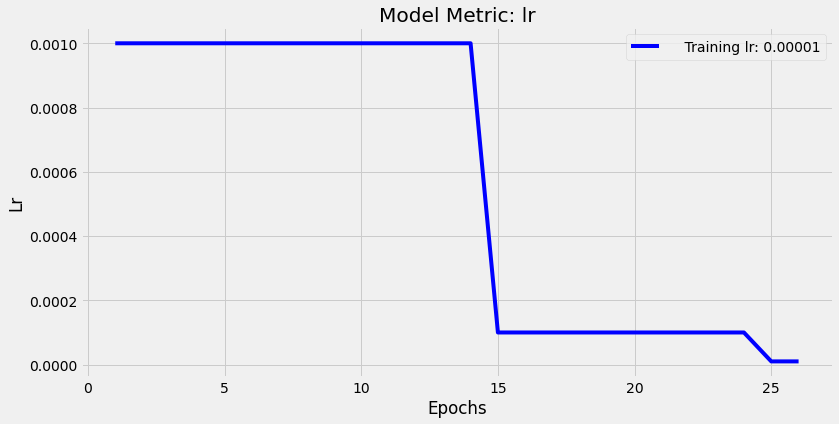

In [127]:
plot_keras_history(history_resnet)

## InceptionNet

In [128]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
inceptionNet = InceptionV3(input_shape = INPUT_SHAPE,
                           weights = 'imagenet',
                           include_top = False)

87924736/87910968 [==============================] - 1s 0us/step


In [132]:
inceptionNet.trainable = False

batch_normalization = layers.BatchNormalization()
pooling = layers.GlobalAveragePooling2D(name='avg_pool')
prediction_layer = layers.Dense(len(np.unique(Y_TRAIN)),activation = 'softmax')

In [133]:
inceptionv3 = models.Sequential([
    inceptionNet,
    batch_normalization,
    pooling,
    prediction_layer
])

In [134]:
inceptionv3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 batch_normalization_98 (Bat  (None, 4, 4, 2048)       8192      
 chNormalization)                                                
                                                                 
 avg_pool (GlobalAveragePool  (None, 2048)             0         
 ing2D)                                                          
                                                                 
 dense_8 (Dense)             (None, 135)               276615    
                                                                 
Total params: 22,087,591
Trainable params: 280,711
Non-trainable params: 21,806,880
_________________________________________________________________


In [135]:
inceptionv3.compile(optimizer = 'adam', 
                    loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                    metrics = ['accuracy'])

In [136]:
history_inception = inceptionv3.fit(X_TRAIN,Y_TRAIN,
                                    epochs = EPOCHS,
                                    validation_split = 0.25,
                                    callbacks = es)


Epoch 1/100
96/96 [==============================] - 13s 85ms/step - loss: 2.2111 - accuracy: 0.5393 - val_loss: 1.0520 - val_accuracy: 0.7583 - lr: 0.0010
Epoch 2/100
96/96 [==============================] - 6s 58ms/step - loss: 0.2999 - accuracy: 0.9564 - val_loss: 0.6283 - val_accuracy: 0.8546 - lr: 0.0010
Epoch 3/100
96/96 [==============================] - 6s 58ms/step - loss: 0.0926 - accuracy: 0.9967 - val_loss: 0.5323 - val_accuracy: 0.8684 - lr: 0.0010
Epoch 4/100
96/96 [==============================] - 6s 58ms/step - loss: 0.0445 - accuracy: 1.0000 - val_loss: 0.5036 - val_accuracy: 0.8644 - lr: 0.0010
Epoch 5/100
96/96 [==============================] - 5s 56ms/step - loss: 0.0275 - accuracy: 1.0000 - val_loss: 0.4763 - val_accuracy: 0.8723 - lr: 0.0010
Epoch 6/100
96/96 [==============================] - 5s 57ms/step - loss: 0.0194 - accuracy: 1.0000 - val_loss: 0.4638 - val_accuracy: 0.8723 - lr: 0.0010
Epoch 7/100
95/96 [============================>.] - ETA: 0s - loss: 

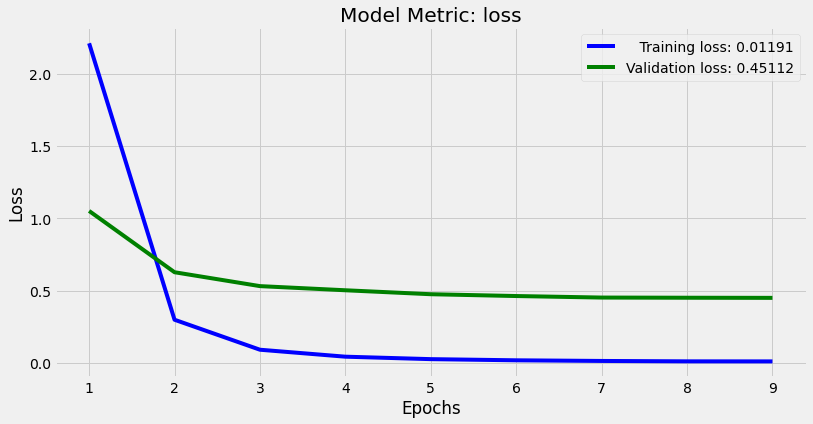

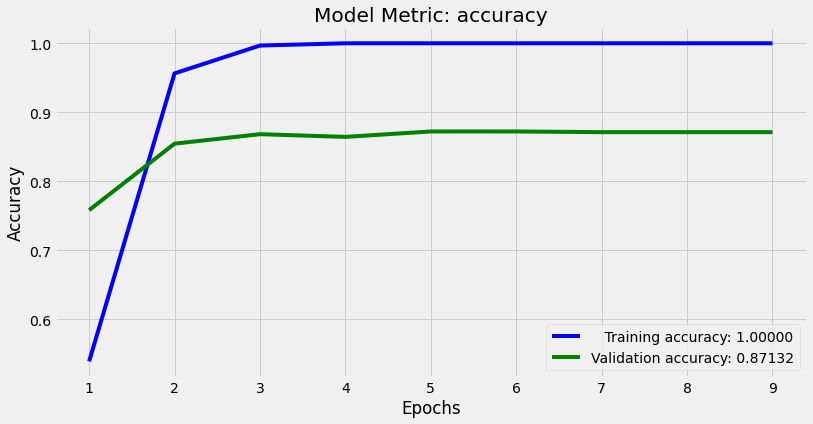

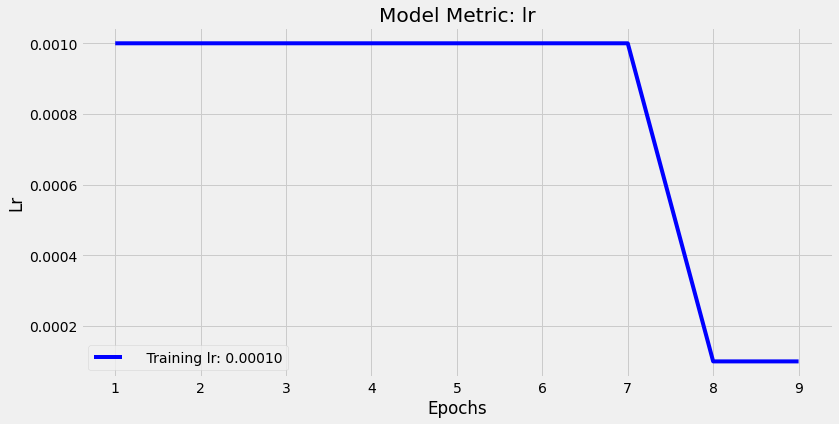

In [137]:
plot_keras_history(history_inception)

In [138]:
predictions = get_predictions_from_model(inceptionv3,X_TEST)
label_pred = get_original_labels(predictions,encoder)
label_true = get_original_labels(Y_TEST,encoder)

predictions_dataframe = pd.DataFrame({'Ytrue':label_true.reshape(-1), 'Ypred':label_pred.reshape(-1)})
correct_predictions = predictions_dataframe[predictions_dataframe['Ytrue']==predictions_dataframe['Ypred']]
false_predictions = predictions_dataframe[predictions_dataframe['Ytrue']!=predictions_dataframe['Ypred']]

print(f"Test Sample size {X_TEST.shape[0]}")
print(f"Number of correct Predctions {correct_predictions.shape[0]}")
print(f"Accuracy of Test Dataset {correct_predictions.shape[0]/X_TEST.shape[0]:.4f}")

Test Sample size 1357
Number of correct Predctions 1212
Accuracy of Test Dataset 0.8931


In [139]:
inceptionv3.save("/content/drive/MyDrive/models/inception.h5")
inceptionv3.save_weights("/content/drive/MyDrive/models/inception_weights.h5")

In [143]:
!ls -lh /content/drive/MyDrive/models/

total 12G
drwx------ 2 root root 4.0K Aug 23 16:08 assets
-rw------- 1 root root 6.5G Aug 27 15:05 conv_model.h5
-rw------- 1 root root 2.2G Aug 27 15:06 conv_model_weights.h5
-rw------- 1 root root 455M Aug 27 07:21 data.npz
-rw------- 1 root root  87M Aug 27 18:07 inception.h5
-rw------- 1 root root  85M Aug 27 18:07 inception_weights.h5
-rw------- 1 root root 949K Aug 24 13:12 keras_metadata.pb
-rw------- 1 root root 193M Aug 27 17:53 resnet.h5
-rw------- 1 root root 125M Aug 27 17:53 resnet_weights.h5
-rw------- 1 root root 5.1M Aug 24 13:12 saved_model.pb
drwx------ 2 root root 4.0K Aug 24 13:12 variables
drwx------ 2 root root 4.0K Aug 23 16:08 vgg
-rw------- 1 root root 1.1G Aug 27 17:08 vgg16.h5
-rw------- 1 root root 411M Aug 27 17:08 vgg16_weights.h5
